In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import (
    KaplanMeierFitter, NelsonAalenFitter, BreslowFlemingHarringtonFitter,
    ExponentialFitter, WeibullFitter, LogLogisticFitter, LogNormalFitter,
    GeneralizedGammaFitter, MixtureCureFitter, PiecewiseExponentialFitter, SplineFitter
)
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from scipy.integrate import quad
import seaborn as sns


In [4]:
df = pd.read_csv("telco.csv")

df.head(10)

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No
5,6,Zone 2,41,39,Unmarried,17,78,High school degree,No,Female,No,No,No,Plus service,No
6,7,Zone 3,45,22,Married,2,19,High school degree,No,Female,No,Yes,No,E-service,Yes
7,8,Zone 2,38,35,Unmarried,5,76,High school degree,No,Male,Yes,Yes,Yes,Total service,No
8,9,Zone 3,45,59,Married,7,166,College degree,No,Male,No,No,Yes,Plus service,No
9,10,Zone 1,68,41,Married,21,72,Did not complete high school,No,Male,No,No,No,E-service,No



 Model Comparison:
                       Model  Log-Likelihood          AIC
6                  LogNormal    -1602.517574  3209.035147
7           GeneralizedGamma    -1602.504453  3211.008906
9       PiecewiseExponential    -1602.002732  3214.005463
5                LogLogistic    -1605.207738  3214.415476
3                Exponential    -1606.980407  3215.960813
4                    Weibull    -1606.430585  3216.861171
0                KaplanMeier             NaN          NaN
1                NelsonAalen             NaN          NaN
2   BreslowFlemingHarrington             NaN          NaN
8                MixtureCure             NaN          NaN
10                    Spline             NaN          NaN


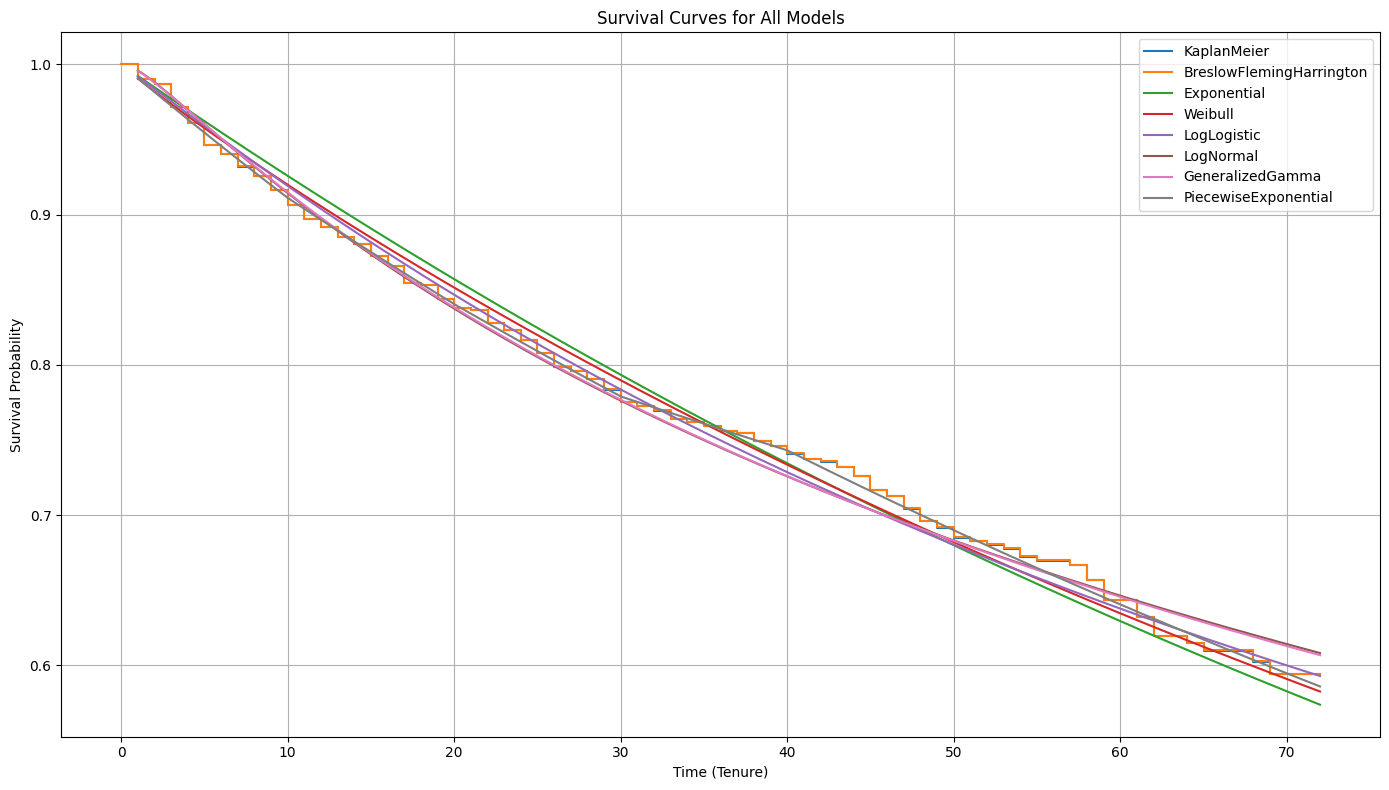


 Best Model Recommendation Based on AIC:
Model               LogNormal
Log-Likelihood   -1602.517574
AIC               3209.035147
Name: 6, dtype: object


In [5]:
df = pd.read_csv("telco.csv")
df.columns = df.columns.str.strip() 

required_cols = ['tenure', 'churn']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Missing required column: {col}")

df['duration'] = df['tenure']
df['event_observed'] = df['churn'].map({'Yes': 1, 'No': 0})

df.drop(columns=['ID', 'tenure', 'churn'], inplace=True)

categorical_cols = df.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

T = df['duration']
E = df['event_observed']

model_classes = {
    "KaplanMeier": KaplanMeierFitter,
    "NelsonAalen": NelsonAalenFitter,
    "BreslowFlemingHarrington": BreslowFlemingHarringtonFitter,
    "Exponential": ExponentialFitter,
    "Weibull": WeibullFitter,
    "LogLogistic": LogLogisticFitter,
    "LogNormal": LogNormalFitter,
    "GeneralizedGamma": GeneralizedGammaFitter,
    "MixtureCure": MixtureCureFitter,
    "PiecewiseExponential": PiecewiseExponentialFitter,
    "Spline": SplineFitter
}

fitted_models = {}
results = []

for name, model_class in model_classes.items():
    try:
        if name == "MixtureCure":
            model = model_class(penalizer=0.01).fit(T, E)
        elif name == "PiecewiseExponential":
            breakpoints = [10, 20, 30, 40]
            model = model_class(breakpoints=breakpoints).fit(T, E)
        elif name == "Spline":
            model = model_class(k=3).fit(T, E)
        else:
            model = model_class().fit(T, E)

        fitted_models[name] = model

        results.append({
            "Model": name,
            "Log-Likelihood": getattr(model, 'log_likelihood_', np.nan),
            "AIC": getattr(model, 'AIC_', np.nan)
        })

    except Exception as e:
        fitted_models[name] = f"Error: {e}"
        results.append({
            "Model": name,
            "Log-Likelihood": np.nan,
            "AIC": np.nan
        })


comparison_df = pd.DataFrame(results).sort_values(by="AIC", na_position='last')
print("\n Model Comparison:")
print(comparison_df)

plt.figure(figsize=(14, 8))
for name, model in fitted_models.items():
    if not isinstance(model, str):
        try:
            model.plot_survival_function(ci_show=False, label=name)
        except:
            continue

plt.title("Survival Curves for All Models")
plt.xlabel("Time (Tenure)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

best_model = comparison_df.dropna().sort_values(by='AIC').iloc[0]
print("\n Best Model Recommendation Based on AIC:")
print(best_model)


As we see the best model is Log Normal with AIC score of ~3209, therefore I will choose it

In [6]:
aft_models = {
    "WeibullAFT": WeibullAFTFitter(),
    "LogNormalAFT": LogNormalAFTFitter(),
    "LogLogisticAFT": LogLogisticAFTFitter()
}

aft_coefficients = {}

for name, model in aft_models.items():
    try:
        model.fit(df, duration_col="duration", event_col="event_observed")

        # Use the correct parameter row based on model
        if name == "WeibullAFT":
            coefs = model.params_.loc['lambda_']
        elif name in ["LogNormalAFT", "LogLogisticAFT"]:
            coefs = model.params_.loc['mu_']
        else:
            raise ValueError(f"No coefficient row defined for model: {name}")

        aft_coefficients[name] = coefs

    except Exception as e:
        print(f"{name} failed: {e}")


# Combine into comparison table
coeff_df = pd.DataFrame(aft_coefficients)
print("\n Feature Coefficients Comparison (AFT Models):\n")
print(coeff_df.round(3))


LogLogisticAFT failed: 'mu_'

 Feature Coefficients Comparison (AFT Models):

           WeibullAFT  LogNormalAFT
covariate                          
address         0.044         0.044
age             0.029         0.035
custcat         0.341         0.444
ed              0.060         0.058
forward        -0.326        -0.385
gender         -0.032         0.025
income          0.001         0.001
internet       -0.768        -0.800
marital        -0.407        -0.489
region          0.063         0.032
retire          0.220        -0.031
voice          -0.453        -0.636
Intercept       3.191         2.663


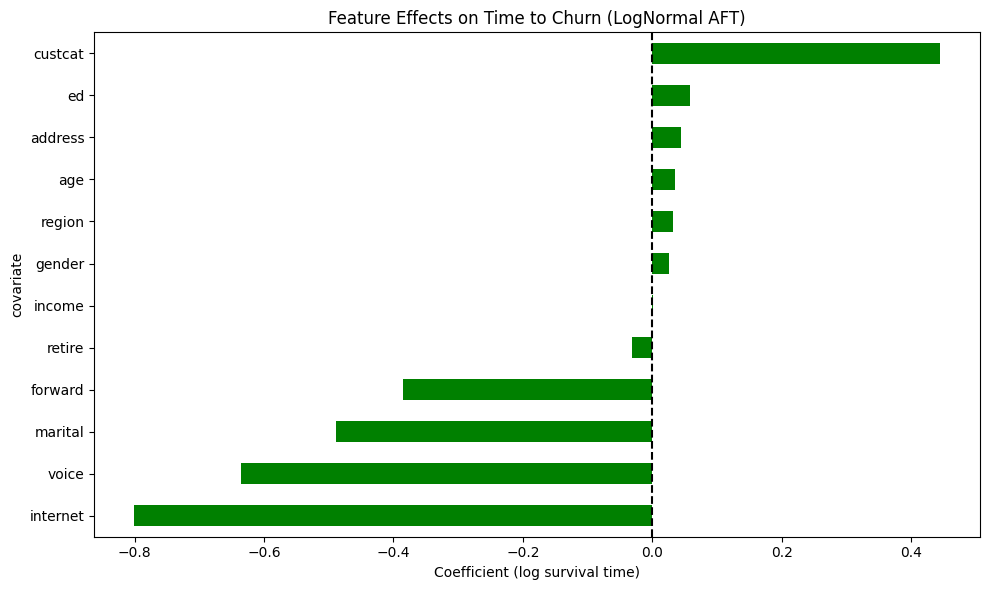

In [7]:
model_to_plot = coeff_df["LogNormalAFT"].drop("Intercept")

plt.figure(figsize=(10, 6))
model_to_plot.sort_values().plot(kind='barh', color='green')
plt.axvline(0, color='black', linestyle='--')
plt.title("Feature Effects on Time to Churn (LogNormal AFT)")
plt.xlabel("Coefficient (log survival time)")
plt.tight_layout()
plt.show()

The LogNormal model achieved the best fit with the lowest AIC (3209) and highest log-likelihood, making it the most suitable model among those compared. The survival curves show that most models closely follow a similar trend, but LogNormal aligns best overall. Feature importance analysis from the LogNormal AFT model reveals that having internet or voice services significantly decreases time to churn, while customer category (custcat) strongly increases retention. Overall, the model not only performs well statistically but also gives actionable insights for targeting churn risk.

CLV

In [8]:
significant_features = ['age', 'income', 'address', 'gender', 'internet']

final_model = LogNormalAFTFitter()
final_model.fit(df[['duration', 'event_observed'] + significant_features], duration_col='duration', event_col='event_observed')

discount_rate = 0.01 

df['ARPU'] = df['income']

def compute_clv(row):
    x = row[significant_features].to_frame().T
    survival_func = lambda t: final_model.predict_survival_function(x, times=[t]).values[0][0] * np.exp(-discount_rate * t)
    integral, _ = quad(survival_func, 0, 100)
    return row['ARPU'] * integral

df['CLV'] = df.apply(compute_clv, axis=1)

In [9]:
df

,region,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,duration,event_observed,ARPU,CLV
0,1,44,0,9,64,0,0,1,0,0,1,0,13,1,64,3261.171323
1,2,33,0,7,136,3,0,1,1,0,1,3,11,1,136,6312.641975
2,2,52,0,24,116,1,0,0,0,0,0,2,68,0,116,6871.639510
3,1,33,1,12,33,2,0,0,0,0,0,0,33,1,33,1572.876661
4,1,30,0,9,30,1,0,1,0,0,1,2,23,0,30,1334.999086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,39,1,0,27,4,0,0,0,0,0,0,10,0,27,1156.230309
996,0,34,1,2,22,3,0,0,0,0,0,0,7,0,22,915.998571
997,2,59,1,40,944,3,0,0,1,1,1,3,67,0,944,59165.505117
998,2,49,1,18,87,2,0,0,1,0,1,2,70,0,87,4926.758896


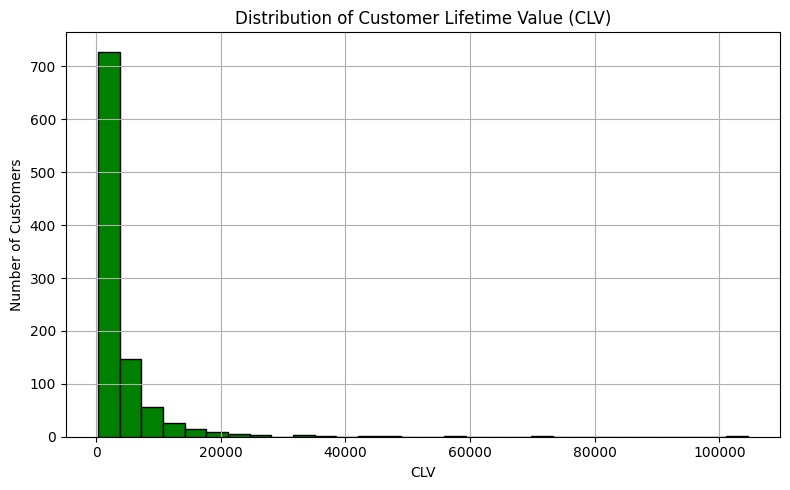

In [10]:
plt.figure(figsize=(8, 5))
df['CLV'].plot(kind='hist', bins=30, color='green', edgecolor='black')
plt.title("Distribution of Customer Lifetime Value (CLV)")
plt.xlabel("CLV")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

Most customers are low spenders or short-tenured, but a few high-value customers are driving major profit.

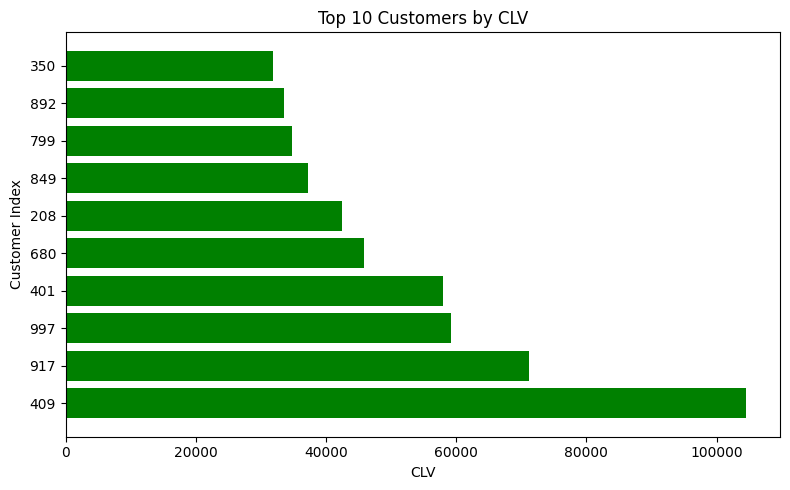

In [11]:
top_customers = df.sort_values(by="CLV", ascending=False).head(10)
plt.figure(figsize=(8, 5))
plt.barh(top_customers.index.astype(str), top_customers["CLV"], color='green')
plt.title("Top 10 Customers by CLV")
plt.xlabel("CLV")
plt.ylabel("Customer Index")
plt.tight_layout()
plt.show()


The top customers have CLVs ranging from ~35,000 to over 100,000.

/var/folders/bj/wz4dxtdn6fbgd7thsdmdcpjm0000gn/T/ipykernel_18142/2876424441.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="region", y="CLV", data=df, palette="pastel")


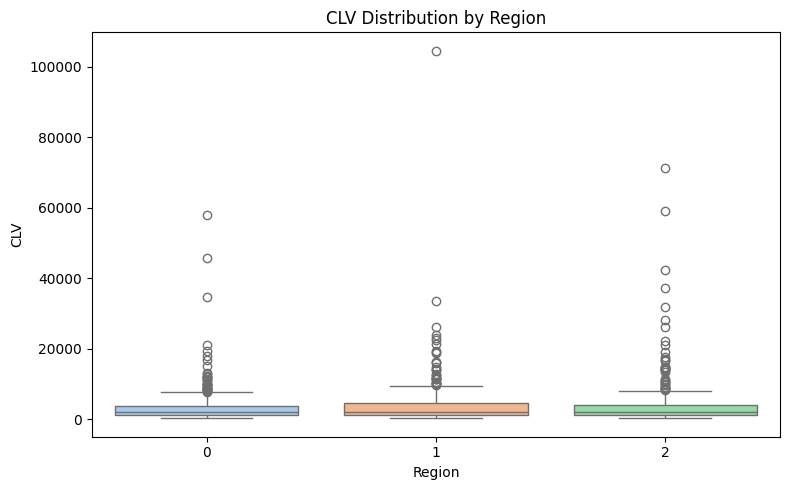

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="region", y="CLV", data=df, palette="pastel")
plt.title("CLV Distribution by Region")
plt.xlabel("Region")
plt.ylabel("CLV")
plt.tight_layout()
plt.show()

This suggests regional differences in customer value — possibly due to economic factors, service access, or marketing effectiveness.

/var/folders/bj/wz4dxtdn6fbgd7thsdmdcpjm0000gn/T/ipykernel_18142/2304429666.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("age_group")["CLV"].mean().plot(kind="bar", color="green", edgecolor="black")


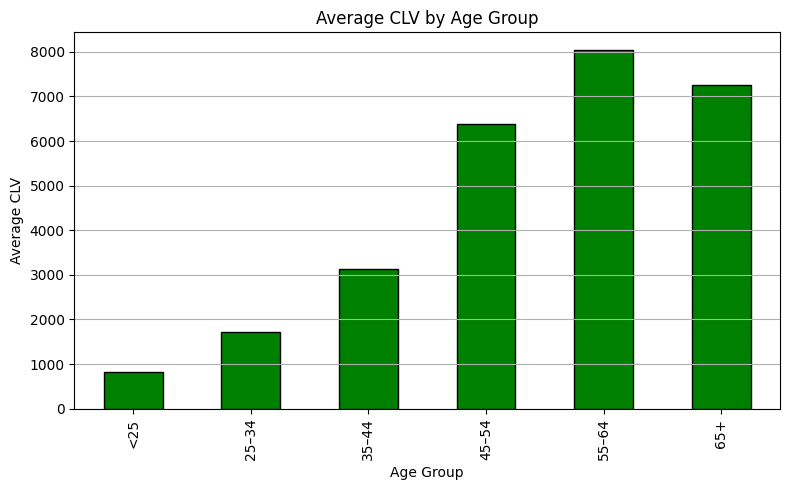

In [13]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100], labels=["<25", "25–34", "35–44", "45–54", "55–64", "65+"])

plt.figure(figsize=(8, 5))
df.groupby("age_group")["CLV"].mean().plot(kind="bar", color="green", edgecolor="black")
plt.title("Average CLV by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average CLV")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

This chart shows that average CLV increases with age, peaking in the 55–64 age group, indicating that older customers tend to be significantly more valuable over their lifetime.

In [15]:
final_model.predict_survival_function(df, times=[12]).mean()
survival_12 = final_model.predict_survival_function(df, times=[12]).T[12]
at_risk = (survival_12 < 0.8).sum()
print("At risk customers: ", at_risk)

At risk customers:  177


In [16]:
df["CLV"].mean()

np.float64(3954.1407066753072)

#### Summary

I compared multiple models using AIC and survival curve visualization and selected LogNormal based on best fit. Feature coefficients were interpreted to identify drivers of churn, and CLV was computed using predicted survival times and income. CLV was further analyzed across customer segments such as age group, region, and category to identify high-value patterns. The entire workflow demonstrates how survival models can be effectively used for retention-focused customer analytics.